# 1. Parzen windows density estimates are given by $\hat{p}(x)=\frac{1}{n}\sum_ik(x,x_i)$. Prove that for binary classification the function $\hat{p}(x,y=1)-\hat{p}(x,y=-1)$, as obtained by Parzen windows is equivalent to Nadaraya–Watson classification.

The equation of Nadaraya–Watson classification is:
$$f(q)=\sum_iv_i\frac{\alpha(q,k_i)}{\sum_j\alpha(q,k_i)}$$
As the label of binary classification is ${1,-1}$, so the equation can be modified as:
$$f(q)=\sum^{y=1}\hat{p}(x)-\sum^{y=-1}\hat{p}(x)=\hat{p}(x,y=1)-\hat{p}(x,y=-1)$$

# 2. Implement stochastic gradient descent to learn a good value for kernel widths in Nadaraya–Watson regression.

## 2.1 What happens if you just use the above estimates to minimize $(f(x_i)-y_i)^2$ directly? Hint: $y_i$ is part of the terms used to compute $f$.

If we just use the above estimates to minimize $(f(x_i)-y_i)^2$ directly, we may encounter some problems, such as:
- The loss function is not convex in h, so we may get stuck in a local minimum or a saddle point.
- The loss function is sensitive to outliers, since they can have a large influence on the numerator and denominator of $f(x_i)$.
- The loss function does not account for the bias-variance trade-off, since a smaller h may lead to overfitting and a larger h may lead to underfitting.

This is because the estimated value $f(x_i)$ is part of the terms used to compute $f$ itself. In other words, you would be trying to optimize a circular dependency, and standard optimization techniques may not converge or provide meaningful results.

In [71]:
import sys
import torch.nn as nn
import torch
import warnings
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class SyntheticNWData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""

    def __init__(self, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, 1)
        noise = torch.randn(n, 1) * noise
        self.y = 2 * torch.sin(self.X) + self.X + noise

    def get_tensorloader(self, tensor, train, indices=slice(0, None)):
        tensor = tuple(a[indices] for a in tensor)
        dataset = torch.utils.data.TensorDataset(*tensor)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
    
class NWReg(d2l.Module):
    def __init__(self, x_train, y_train, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (1, 1), requires_grad=True)
        
    def forward(self, X):
        y_hat, attention_w = self.nadaraya_watson(self.x_train, self.y_train, X)
        return y_hat
    
    def loss(self, y_hat, y):
        l = (y_hat - y)**2 / 2
        return l.mean()
    
    def configure_optimizers(self):
        return d2l.SGD([self.w], self.lr)
    
    def nadaraya_watson(self, x_train, y_train, x_val):
        dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
        # Each column/row corresponds to each query/key
        k = torch.exp(-dists**2 /2/(torch.pow(self.w, 2)+0.00001))
        # Normalization over keys for each query
        attention_w = k / k.sum(0)
        y_hat = y_train.T@attention_w
        return y_hat, attention_w

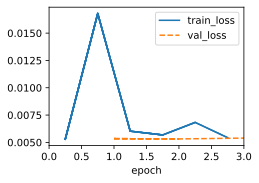

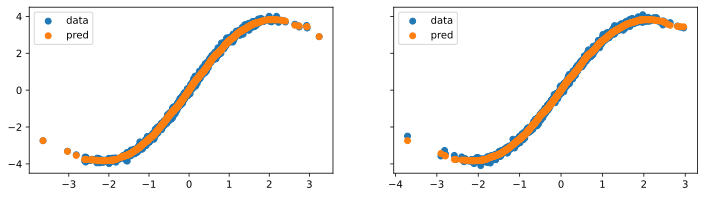

In [27]:
data = SyntheticNWData(batch_size=1, noise=0.1)
model = NWReg(x_train=data.X[:data.num_train], y_train=data.y[:data.num_train], lr=0.1)
trainer = d2l.Trainer(max_epochs=3) #, num_gpus=1
trainer.fit(model, data)
fig, axes = d2l.plt.subplots(1, 2, sharey=True, figsize=(12, 3))
axes[0].scatter(data.X[:data.num_train],data.y[:data.num_train],label='data')
axes[0].scatter(data.X[:data.num_train],model(data.X[:data.num_train]).detach().numpy() ,label='pred')
axes[0].legend()
axes[1].scatter(data.X[-data.num_train:],data.y[-data.num_train:],label='data')
axes[1].scatter(data.X[-data.num_train:],model(data.X[-data.num_train:]).detach().numpy() ,label='pred')
axes[1].legend()

## 2.2 Remove $(x_i,y_i)$ from the estimate for $f(x)$ and optimize over the kernel widths. Do you still observe overfitting?

If you remove $(x_i, y_i)$ from the estimate for $f(x)$ and optimize only over the kernel widths, you essentially decouple the bandwidth optimization from the specific data points used for regression. In this scenario, you are optimizing the bandwidths to find the most suitable global smoothing parameters, regardless of the individual data points. This approach is sometimes used in kernel density estimation, where you estimate the probability density function without conditioning on specific data points.

Observations when optimizing only over kernel widths and not conditioning on $(x_i, y_i)$:

1. **Reduced Overfitting**: By not conditioning the bandwidth optimization on the data points, you are less likely to overfit to the training data. This is because you are searching for a more general smoothing parameter that works well for the entire dataset.

2. **Global Smoothing**: The optimized bandwidths are likely to result in a more globally smoothed regression function. This means that the estimated $f(x)$ will be less sensitive to individual data points, leading to smoother predictions.

3. **Bias-Variance Trade-Off**: There is a bias-variance trade-off when optimizing bandwidths. Smaller bandwidths lead to low bias but high variance, making the regression function more sensitive to noise. Larger bandwidths introduce bias but reduce variance, resulting in smoother but potentially less accurate predictions.

4. **Validation is Important**: Despite reduced overfitting, it's essential to perform validation to choose appropriate bandwidth values. You can use a validation dataset to select bandwidths that provide the best trade-off between bias and variance. This helps ensure that the model generalizes well to unseen data.

5. **Generalization**: The goal of optimizing bandwidths without conditioning on data points is to build a regression model that generalizes well to a wider range of inputs. This can be beneficial in cases where you want the model to capture underlying patterns in the data while avoiding excessive sensitivity to individual data points.

In summary, optimizing kernel widths without conditioning on specific data points can lead to a regression model with reduced overfitting and a more global smoothing effect. It's a valuable approach when the goal is to build a model that generalizes well to new inputs and avoids sensitivity to noise in the data. However, it's crucial to use validation to select appropriate bandwidth values that balance bias and variance for the specific problem at hand.

In [60]:
class NWRmReg(NWReg):
    def __init__(self, x_train, y_train, lr, sigma=0.01):
        super().__init__(x_train, y_train, lr, sigma=sigma)
        self.save_hyperparameters()
        
    def forward(self, X):
        cur = self.x_train !=X
        x_train = self.x_train[cur]
        y_train = self.y_train[cur]
        y_hat, attention_w = self.nadaraya_watson(x_train, y_train, X)
        return y_hat
    
    def loss(self, y_hat, y):
        l = (y_hat - y)**2 / 2
        return l.mean()
    
    def configure_optimizers(self):
        return d2l.SGD([self.w], self.lr)
    
    def nadaraya_watson(self, x_train, y_train, x_val):
        dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
        # Each column/row corresponds to each query/key
        k = torch.exp(-dists**2 /2/torch.pow(self.w, 2))
        # Normalization over keys for each query
        attention_w = k / k.sum(0)
        y_hat = y_train.T@attention_w
        return y_hat, attention_w


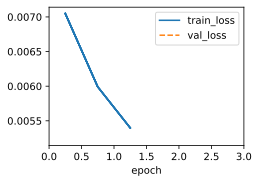

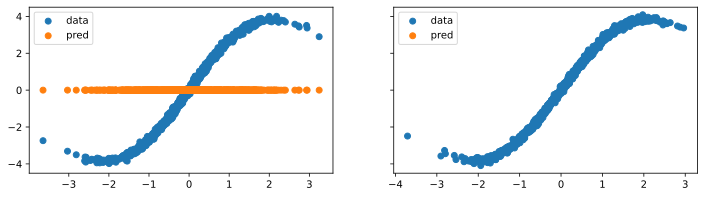

In [72]:
model = NWRmReg(x_train=data.X[:data.num_train], y_train=data.y[:data.num_train], lr=0.1,sigma=)
trainer = d2l.Trainer(max_epochs=3) #, num_gpus=1
trainer.fit(model, data)
fig, axes = d2l.plt.subplots(1, 2, sharey=True, figsize=(12, 3))
axes[0].scatter(data.X[:data.num_train],data.y[:data.num_train],label='data')
axes[0].scatter(data.X[:data.num_train],model(data.X[:data.num_train]).detach().numpy() ,label='pred')
axes[0].legend()
axes[1].scatter(data.X[-data.num_train:],data.y[-data.num_train:],label='data')
axes[1].scatter(data.X[-data.num_train:],model(data.X[-data.num_train:]).detach().numpy() ,label='pred')
axes[1].legend()

# 3. Assume that all $x$ lie on the unit sphere, i.e., all satisfy $\left\|x\right\|=1$. Can you simplify the $\left\|x-x_i\right\|^2$ term in the exponential? Hint: we will later see that this is very closely related to dot product attention.

# 4. Recall that Mack and Silverman (1982) proved that Nadaraya–Watson estimation is consistent. How quickly should you reduce the scale for the attention mechanism as you get more data? Provide some intuition for your answer. Does it depend on the dimensionality of the data? How?